# Air Quality Analysis with Traditional, Machine Learning, and Deep Neural Network based Models

This notebook explores time series forecasting for air quality data using various traditional, machine learning, and deep neural network models. The goal is to analyze historical air quality trends and predict future levels of pollutants. <br> <br>
First, let's import the packages necessary to complete these tasks.

In [ ]:
#Import necessary packages and load Keras using PyTorch
import warnings
warnings.filterwarnings('ignore')

import torch
import os
os.environ["KERAS_BACKEND"] = "torch"

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import keras
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler

## 1. Data Exploration and Visualization

The dataset used in this analysis contains air quality measurements over time for Delhi, India. The focus of this analysis will be on forecasting the PM2.5 levels.

Let's begin by loading and exploring the dataset.

In [ ]:
#Load dataset
dfd = pd.read_csv("delhi_air_quality.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2457 entries, 0 to 2456
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       2457 non-null   object
 1    pm25      2457 non-null   object
 2    pm10      2457 non-null   object
 3    o3        2457 non-null   object
 4    no2       2457 non-null   object
 5    so2       2457 non-null   object
 6    co        2457 non-null   object
 7   aqi score  2457 non-null   int64 
 8   quality    2457 non-null   object
dtypes: int64(1), object(8)
memory usage: 172.9+ KB


### Dataset Overview

The dataset contains time-stamped air quality data. We will first examine the structure and some initial rows of the data.

In [ ]:
dfd.info()

In [ ]:
dfd.head()

,date,pm25,pm10,o3,no2,so2,co,aqi score,quality
0,6/3/2018,,115,17,17,5,8,115,Unhealthy for Sensitive Groups
1,6/4/2018,145,136,17,15,6,8,145,Unhealthy for Sensitive Groups
2,6/5/2018,143,113,13,15,3,8,143,Unhealthy for Sensitive Groups
3,6/6/2018,125,133,8,13,5,9,133,Unhealthy for Sensitive Groups
4,6/7/2018,139,171,8,19,7,11,171,Unhealthy


Notice the incorrect field types, missing values, and unnecessary columns.

### Data Cleaning and Preprocessing

Before proceeding with the analysis, the data will need to be cleaned to handle missing values and ensure the correct data types for time series analysis. This will involve converting the date column to datetime objects and handling any potential missing pollutant readings through interpolation.

In [ ]:
def clean_data(df):
    #Convert empty strings to NaN
    df = df.replace(" ", float("NaN"))

    #Make new dataframe
    df2 = pd.DataFrame()

    #Create new columns
    df2["date"] = pd.to_datetime(df["date"])

    #Convert type
    df2["pm25"] = df[" pm25"].astype(float)

    #Set "Date" as the index column
    df2.set_index('date', inplace=True)

    df2.sort_index(inplace=True)

    for x in df2.columns:
        if pd.isna(df2[x][0]):
            df2[x][0] = df2[x].median()

    #Interpolate missing values
    df2 = df2.interpolate(method='time')

    return df2

In [1]:
#Output some rows of the clean data
dfd = clean_data(dfd)
dfd.head()

NameError: name 'clean_data' is not defined

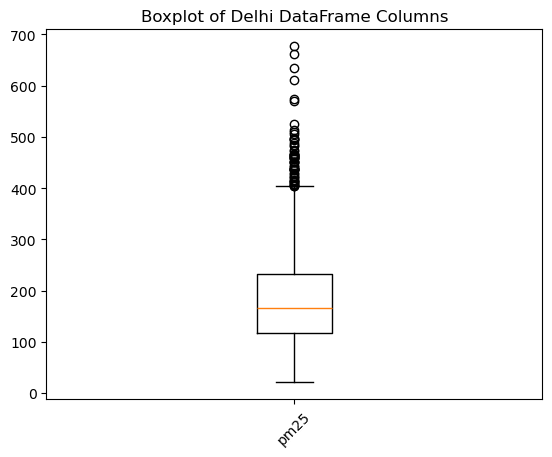

In [ ]:
#Delhi Boxplot
plt.boxplot([dfd[x].dropna() for x in dfd.columns], labels=dfd.columns)
plt.xticks(rotation=45)
plt.title('Boxplot of Delhi DataFrame Columns')
plt.show()

There are quite a few outlier values.

### Visualizing Air Quality Trends

Visualizations are crucial for understanding the patterns and characteristics of time series data. We will plot the PM2.5 levels over time to identify trends, seasonality, and any unusual observations.

In [ ]:
#Select features for detection
features = ["pm25"]

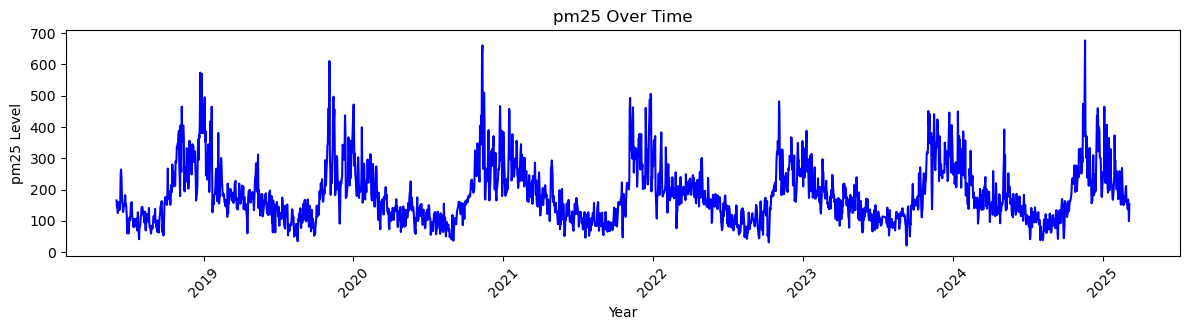

In [ ]:
#Plot data
plt.figure(figsize=(12, 18))

for i, pollutant in enumerate(features):
    plt.subplot(6, 1, i + 1)
    plt.plot(dfd.index, dfd.iloc[:, i], color='blue', label='Delhi')

    plt.xlabel('Year')
    plt.ylabel(f'{pollutant} Level')
    plt.title(f'{pollutant} Over Time')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

There are very obvious seasonal elements to the data.

### Autocorrelation and Partial Autocorrelation Functions (ACF and PACF)

ACF and PACF plots are essential tools for identifying the dependence of observations on previous values. These plots help in determining the appropriate orders for ARIMA and other time series models.

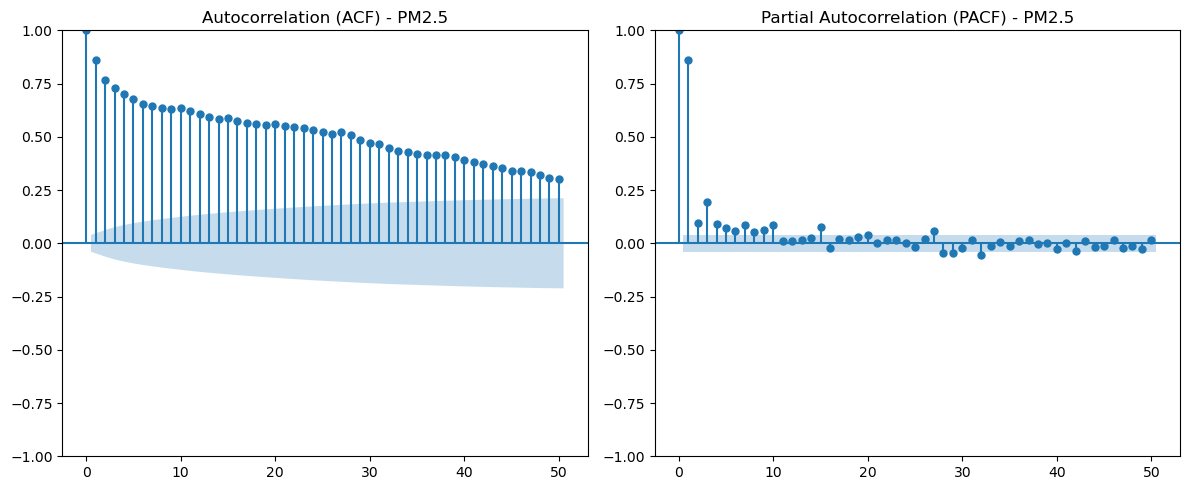

In [ ]:
#ACF & PACF Plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(dfd['pm25'], ax=plt.gca(), lags=50)
plt.title('Autocorrelation (ACF) - PM2.5')

plt.subplot(1, 2, 2)
plot_pacf(dfd['pm25'], ax=plt.gca(), lags=50, method='ywm')
plt.title('Partial Autocorrelation (PACF) - PM2.5')

plt.tight_layout()
plt.show()

The ACF and PACF plots reveal key characteristics of the time series data. The ACF plot shows a gradual decline in autocorrelation, with significant positive values extending up to lag 20, indicating a strong persistence in PM2.5 levels over time. In contrast, the PACF plot displays a sharp spike at lag 1, followed by values that fall within the confidence bounds, suggesting that most of the predictive power lies in the immediate past value. This pattern is indicative of an autoregressive process, which verifies that this data is suitable for predictive forecasting analysis.

### Time Series Decomposition

To further understand the components of the time series, we will perform a seasonal decomposition. This technique separates the data into its trend, seasonal, and residual components, providing insights into the underlying patterns.

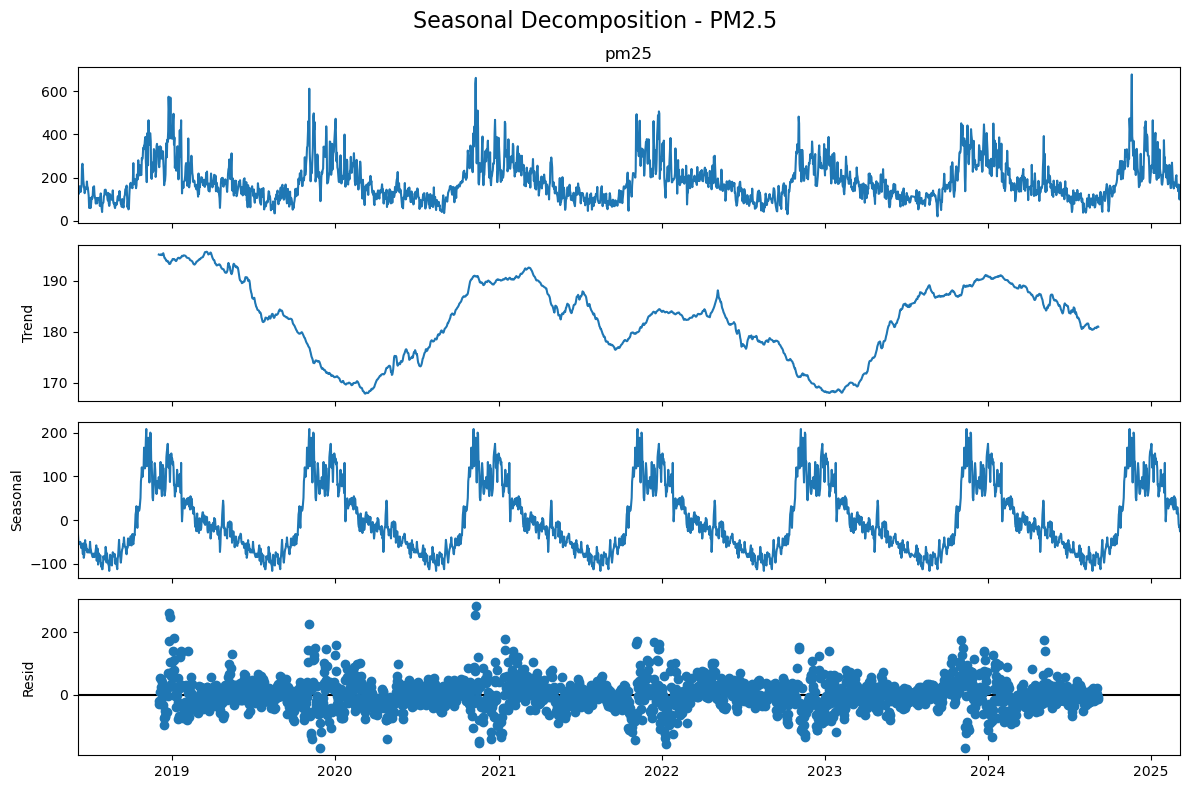

In [ ]:
#Seasonal Decomposition Plot
decomposition = seasonal_decompose(dfd['pm25'], model='additive', period=365)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Seasonal Decomposition - PM2.5', fontsize=16)
plt.tight_layout()
plt.show()

The decomposition chart for the PM2.5 data reveals several important insights. The top plot shows the raw PM2.5 concentrations over time, with noticeable fluctuations and peaks. The "trend" component indicates a general long-term pattern, showing periods of rising and falling pollution levels (Which lines up with the information learned last term with the increased pollution levels in the winter). The "seasonal" component highlights consistent, repeating patterns within each year, suggesting that PM2.5 levels follow a seasonal cycle—likely influenced by weather, human activity, or environmental factors. Finally, the "residual" plot captures the irregular variations not explained by the trend or seasonality, representing noise or anomalies in the data (Which also seems to follow a yearly trend).

## 2. Model Exploration and Evaluation

We will explore a variety of models for forecasting the PM2.5 levels. The models will include both traditional statistical methods and machine learning algorithms. For each model, we will train it on a portion of the data (80%), make predictions on a held-out test set (20%), and evaluate its performance using standard time series forecasting metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared.

In [ ]:
def train_test_split(df2, features):
    #Normalize pollutant levels
    scaler = StandardScaler()
    df2[features] = scaler.fit_transform(df2[features])

    #Train-Test Split (80% Train, 20% Test)
    train_size = int(len(df2) * 0.8)
    train, test = df2.iloc[:train_size], df2.iloc[train_size:]

    return train, test, train_size, scaler

In [ ]:
#Perform train-test split
train_d, test_d, train_size_d, scaler_d = train_test_split(dfd, features)

### Model Evaluation Metrics

For each model, the following metrics will be computed on the test set to assess forecasting accuracy:

*   **Mean Squared Error (MSE):** Measures the average squared difference between the actual and predicted values.
*   **Mean Absolute Error (MAE):** Measures the average absolute difference between the actual and predicted values.
*   **R-squared:** Represents the proportion of the variance in the dependent variable that is predictable from the independent variables.

In [ ]:
#Evaluation
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    df_scores = [mse, mae, r2]
    print("MSE: ",df_scores[0])
    print("MAE: ",df_scores[1])
    print("R^2: ",df_scores[2])

### Traditional Time Series Models

We will now implement and evaluate a traditional time series model.

#### Prophet

Prophet is a time series forecasting model developed by Facebook. It is designed to handle time series with strong seasonality and holiday effects.

In [ ]:
#Prepare data
df_prophet = dfd.reset_index()[["date", "pm25"]].copy()
df_prophet.columns = ["ds", "y"]

#Instantiate and fit the model
model = Prophet()
model.fit(df_prophet)

#Make future dataframe
future = model.make_future_dataframe(periods=len(test_d))
forecast = model.predict(future)

09:36:30 - cmdstanpy - INFO - Chain [1] start processing
09:36:30 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
#Create a future dataframe for predictions
future = model.make_future_dataframe(periods=len(test_d), include_history=False)
prophet_forecast = model.predict(future)
prophet_predictions = prophet_forecast['yhat'].values

In [ ]:
compute_metrics(test_d['pm25'], prophet_predictions)

MSE:  2.3096761779665353
MAE:  1.2745759215649122
R^2:  -1.02421961521524


These metrics are very concerning--especially the $R^{2}$ metric. A negative $R^{2}$ value means that the model did worse at forecasting than just predicting the mean of the data.

### Machine Learning Models

We will also apply machine learning models that can capture complex non-linear relationships in the data.

#### Lasso Regression

Lasso (Least Absolute Shrinkage and Selection Operator) is a linear regression model that includes L1 regularization. It can be used for time series forecasting by treating lagged values as features.

In [ ]:
#Define features (X) and target (y)
split_idx = int(len(dfd) * 0.8)
X = dfd[features]
y = dfd['pm25']

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [ ]:
#Fit the model
lasso_model = make_pipeline(StandardScaler(), Lasso(alpha=0.1, random_state=42))
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

In [ ]:
compute_metrics(test_d['pm25'], lasso_pred)

MSE:  0.012995857538627425
MAE:  0.08644311262162893
R^2:  0.9886103212228682


These values look *much* better than the Prophet values. From here we can see that the model is off by less units (MAE), The squared error is very small (MSE), and the model explains nearly 99% of the variance in the data ($R^{2}$)!

#### LightGBM

LightGBM is a gradient boosting framework that is known for its speed and efficiency. It can be applied to time series forecasting tasks by structuring the problem as a regression problem with time-based features.

In [ ]:
#Create and fit the model
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_predictions = lgbm_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1965, number of used features: 1
[LightGBM] [Info] Start training from score -0.059876


In [ ]:
compute_metrics(test_d['pm25'], lgbm_predictions)

MSE:  0.007620963737268113
MAE:  0.011112147570899731
R^2:  0.9933209233264017


If you thought Lasso regression was promising, look at these values! The model is only off by $0.1$ units, the squared error is $0.007$, and 99.3% of the variance can be explained!

### Deep Neural Network Models

We will also explore the use of a deep neural network model for time series forecasting.

#### LSTM (Long Short-Term Memory)

LSTM is a type of recurrent neural network (RNN) that is well-suited for sequential data like time series. It can capture long-term dependencies in the data.

In [ ]:
#Convert to LSTM-compatible format
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])

    return np.array(X), np.array(y)

In [ ]:
#Create sequences
seq_length_d = min(20, len(dfd) // 10)

X_train_d, y_train_d = create_sequences(train_d[features].values, seq_length_d)
X_test_d, y_test_d = create_sequences(test_d[features].values, seq_length_d)

In [ ]:
#Function to create the model from the training data
def create_model(X_train):
    #Define LSTM model
    inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    lstm_out = keras.layers.LSTM(32)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)
    model = keras.Model(inputs=inputs, outputs=outputs)

    #Compile model
    model.compile(optimizer='adam', loss='mse', metrics=['mse',
        'mae'
    ])

    #Summarize the model
    model.summary()

    return model

In [ ]:
#Create the model and print the summary
model_d = create_model(X_train_d)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 20, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,550 (17.77 KB)

 Trainable params: 4,550 (17.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train Delhi model
model_d.fit(X_train_d, y_train_d, epochs=10, batch_size=16, validation_data=(X_test_d, y_test_d))

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.6712 - mae: 0.5996 - mse: 0.6712 - val_loss: 0.3767 - val_mae: 0.4422 - val_mse: 0.3767
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.3116 - mae: 0.4082 - mse: 0.3116 - val_loss: 0.3353 - val_mae: 0.4209 - val_mse: 0.3353
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2897 - mae: 0.3950 - mse: 0.2897 - val_loss: 0.3114 - val_mae: 0.4081 - val_mse: 0.3114
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2452 - mae: 0.3641 - mse: 0.2452 - val_loss: 0.2898 - val_mae: 0.3832 - val_mse: 0.2898
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2333 - mae: 0.3464 - mse: 0.2333 - val_loss: 0.2813 - val_mae: 0.3803 - val_mse: 0.2813
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2271 - mae: 0.3351 - mse: 0.2271 - val_loss: 0.2891 - val_mae: 0.3724 - val_mse: 0.2891
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.2050 - mae: 0.3281 - mse: 0.205

In [ ]:
#Generate predictions
y_pred_d = model_d.predict(X_test_d)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
loss, mse, mae = model_d.evaluate(X_test, y_test)
print(f"MSE: {mse}, MAE: {mae}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6159 - mae: 0.6227 - mse: 0.6159
MSE: 0.49677586555480957, MAE: 0.5358290076255798


I tried to create my own $R^{2}$ metric as well but it wasn't working so I only have MSE and MAE. From these two metrics, we can see that it is performing still much better than Prophet, but quite a bit worse than Lasso regression or LightGBM.

### Visualizing Forecasts

To visually compare the performance of the different models, we will plot the actual PM2.5 levels against the predicted values from each model on the test set. This will help in understanding how well each model captures the dynamics of the time series.

In [ ]:
#Rescale the predictions back to original values
def rescale(y_train, y_test, y_pred, scaler):
    y_train_rescaled = scaler.inverse_transform(y_train)
    y_test_rescaled = scaler.inverse_transform(y_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    return y_train_rescaled, y_test_rescaled, y_pred_rescaled

In [ ]:
#Rescale data for plotting
y_train_rescaled_d, y_test_rescaled_d, y_pred_rescaled_d = rescale(y_train_d, y_test_d, y_pred_d, scaler_d)
prophet_rescaled = scaler_d.inverse_transform(prophet_predictions.reshape(-1, 1))
lasso_rescaled = scaler_d.inverse_transform(lasso_pred.reshape(-1, 1))
lgbm_rescaled = scaler_d.inverse_transform(lgbm_predictions.reshape(-1, 1))

In [ ]:
#Get corresponding dates
train_dates_d = dfd.index[seq_length_d:train_size_d]
test_dates_d = dfd.index[train_size_d + seq_length_d:]

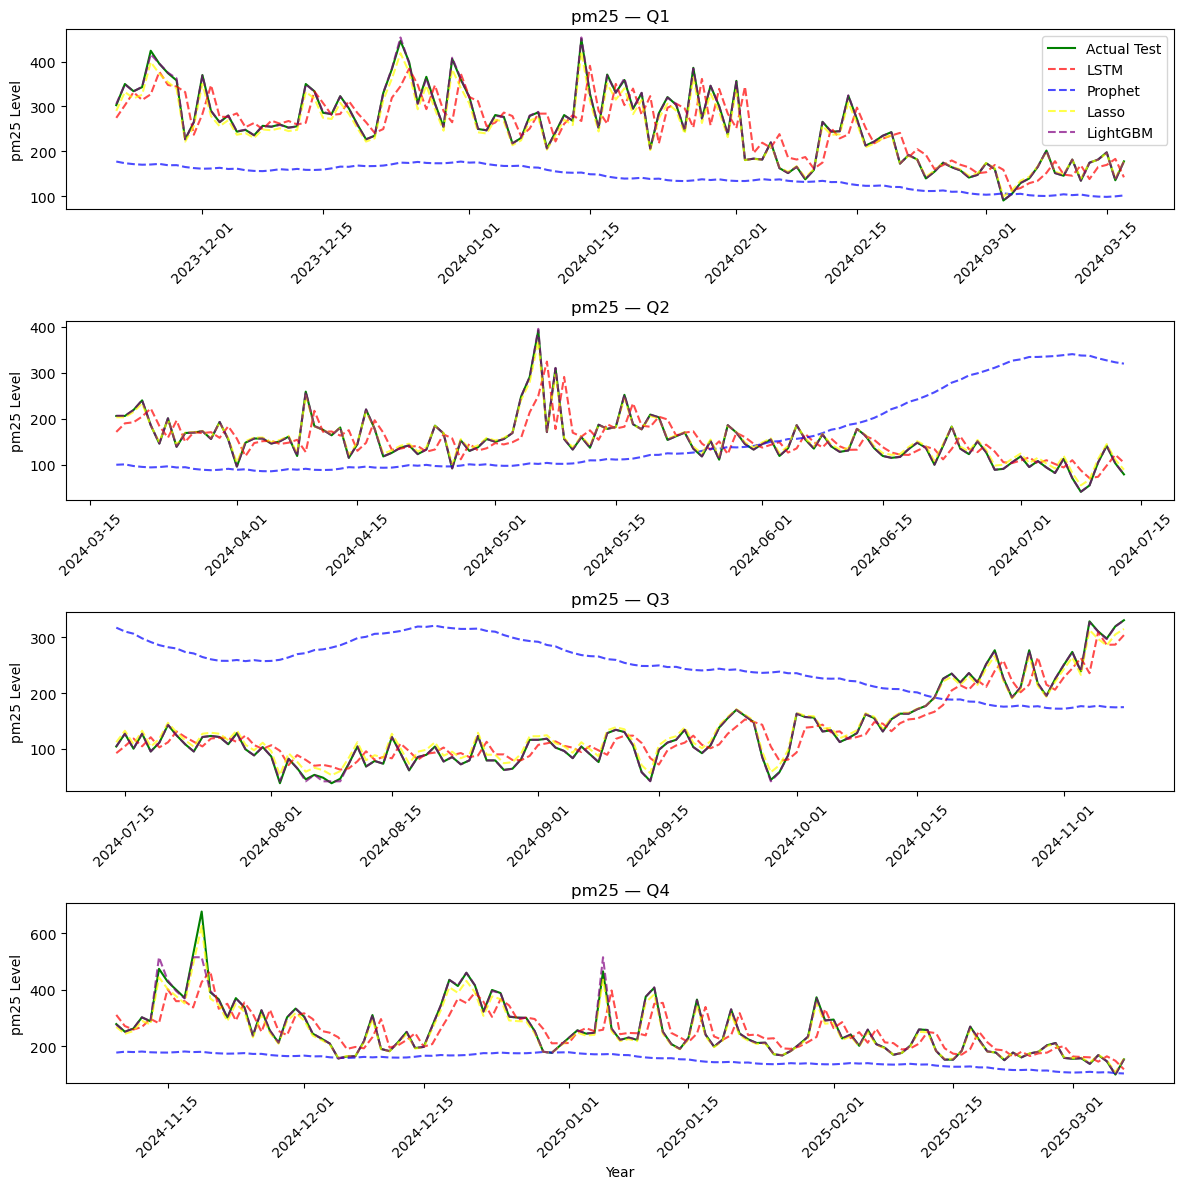

In [ ]:
quarter = len(test_dates_d) // 4 #Break into quarters so it is easier to see how the model differ

plt.figure(figsize=(12, 12))

for i, pollutant in enumerate(features):
    #Q1
    plt.subplot(4, 1, 1)
    plt.plot(test_dates_d[:quarter], y_test_rescaled_d[:quarter, i], color='green', label='Actual Test' if i == 0 else "")
    plt.plot(test_dates_d[:quarter], y_pred_rescaled_d[:quarter, i], color='red', linestyle='dashed', label='LSTM' if i == 0 else "", alpha=0.7)
    plt.plot(test_d.index[20:quarter+20], prophet_rescaled[20:quarter+20, i], color='blue', linestyle='dashed', label='Prophet' if i == 0 else "", alpha=0.7)
    plt.plot(test_d.index[20:quarter+20], lasso_rescaled[20:quarter+20, i], color='yellow', linestyle='dashed', label='Lasso' if i == 0 else "", alpha=0.7)
    plt.plot(test_d.index[20:quarter+20], lgbm_rescaled[20:quarter+20, i], color='purple', linestyle='dashed', label='LightGBM' if i == 0 else "", alpha=0.7)
    plt.title(f'{pollutant} — Q1')
    plt.ylabel(f'{pollutant} Level')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)

    #Q2
    plt.subplot(4, 1, 2)
    plt.plot(test_dates_d[quarter:2*quarter], y_test_rescaled_d[quarter:2*quarter, i], color='green')
    plt.plot(test_dates_d[quarter:2*quarter], y_pred_rescaled_d[quarter:2*quarter, i], color='red', linestyle='dashed', alpha=0.7)
    plt.plot(test_d.index[quarter+20:2*quarter+20], prophet_rescaled[quarter+20:2*quarter+20, i], color='blue', linestyle='dashed', alpha=0.7)
    plt.plot(test_d.index[quarter+20:2*quarter+20], lasso_rescaled[quarter+20:2*quarter+20, i], color='yellow', linestyle='dashed', alpha=0.7)
    plt.plot(test_d.index[quarter+20:2*quarter+20], lgbm_rescaled[quarter+20:2*quarter+20, i], color='purple', linestyle='dashed', alpha=0.7)
    plt.title(f'{pollutant} — Q2')
    plt.ylabel(f'{pollutant} Level')
    plt.xticks(rotation=45)

    #Q3
    plt.subplot(4, 1, 3)
    plt.plot(test_dates_d[2*quarter:3*quarter], y_test_rescaled_d[2*quarter:3*quarter, i], color='green')
    plt.plot(test_dates_d[2*quarter:3*quarter], y_pred_rescaled_d[2*quarter:3*quarter, i], color='red', linestyle='dashed', alpha=0.7)
    plt.plot(test_d.index[2*quarter+20:3*quarter+20], prophet_rescaled[2*quarter+20:3*quarter+20, i], color='blue', linestyle='dashed', alpha=0.7)
    plt.plot(test_d.index[2*quarter+20:3*quarter+20], lasso_rescaled[2*quarter+20:3*quarter+20, i], color='yellow', linestyle='dashed', alpha=0.7)
    plt.plot(test_d.index[2*quarter+20:3*quarter+20], lgbm_rescaled[2*quarter+20:3*quarter+20, i], color='purple', linestyle='dashed', alpha=0.7)
    plt.title(f'{pollutant} — Q3')
    plt.ylabel(f'{pollutant} Level')
    plt.xticks(rotation=45)

    #Q4
    plt.subplot(4, 1, 4)
    plt.plot(test_dates_d[3*quarter:], y_test_rescaled_d[3*quarter:, i], color='green')
    plt.plot(test_dates_d[3*quarter:], y_pred_rescaled_d[3*quarter:, i], color='red', linestyle='dashed', alpha=0.7)
    plt.plot(test_d.index[3*quarter+20:], prophet_rescaled[3*quarter+20:, i], color='blue', linestyle='dashed', alpha=0.7)
    plt.plot(test_d.index[3*quarter+20:], lasso_rescaled[3*quarter+20:, i], color='yellow', linestyle='dashed', alpha=0.7)
    plt.plot(test_d.index[3*quarter+20:], lgbm_rescaled[3*quarter+20:, i], color='purple', linestyle='dashed', alpha=0.7)
    plt.title(f'{pollutant} — Q4')
    plt.xlabel('Year')
    plt.ylabel(f'{pollutant} Level')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

## 3. Best Model Selection and Explanation

After evaluating the performance of all the explored models based on the chosen metrics and visual inspection of the forecasts, it is time to determine which model performed the best... <br> <br>
LightGBM turns out to be the best model that I tested for this data. The evaluation metrics showed extreme promise and the comparison with the actual test data proved that even more. Besides three slight differences in the fourth quarter, LightGBM follows the test data EXACTLY! <br> <br> Lasso Regression comes in a close second; always being close to the actual data, but never right on. <br> <br> The LSTM looks decent from afar (as was seen last term), but when zoomed in, you can see that it is very similar to the test data, just offset a little. This is because it isn't really predicting the next value, it is just choosing the value from the previous time step. <br> <br> Then there's Prophet. I don't know what it was thinking, but it didn't even try to be accurate. When the real values were high, Prophet was low and vice versa.